###  Importing Libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

### Applying transforms

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Loading dataset

In [5]:
train = datasets.MNIST('./', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./', train=False, download=True, transform=test_transforms)

### Setting up the device and loaders

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Model Definition

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

### Training and Testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = OneCycleLR(optimizer, max_lr=0.020,epochs=15,steps_per_epoch=len(train_loader))


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.29727157950401306 Batch_id=468 Accuracy=62.01: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2265, Accuracy: 9586/10000 (95.86%)

EPOCH: 2


Loss=0.10256924480199814 Batch_id=468 Accuracy=96.35: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0792, Accuracy: 9766/10000 (97.66%)

EPOCH: 3


Loss=0.0540480799973011 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:11<00:00, 41.83it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.0699489638209343 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:11<00:00, 40.55it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.11496192216873169 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.06877096742391586 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:11<00:00, 41.18it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.04832543432712555 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.05326010659337044 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 39.21it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.027161546051502228 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.017801331356167793 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.82it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.015464474447071552 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.007297795731574297 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9952/10000 (99.52%)

EPOCH: 13


Loss=0.013683521188795567 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.028861798346042633 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 37.40it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9952/10000 (99.52%)

EPOCH: 15


Loss=0.005381759721785784 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s] 



Test set: Average loss: 0.0158, Accuracy: 9952/10000 (99.52%)



### Plotting Graphs

Text(0.5, 1.0, 'Test Accuracy')

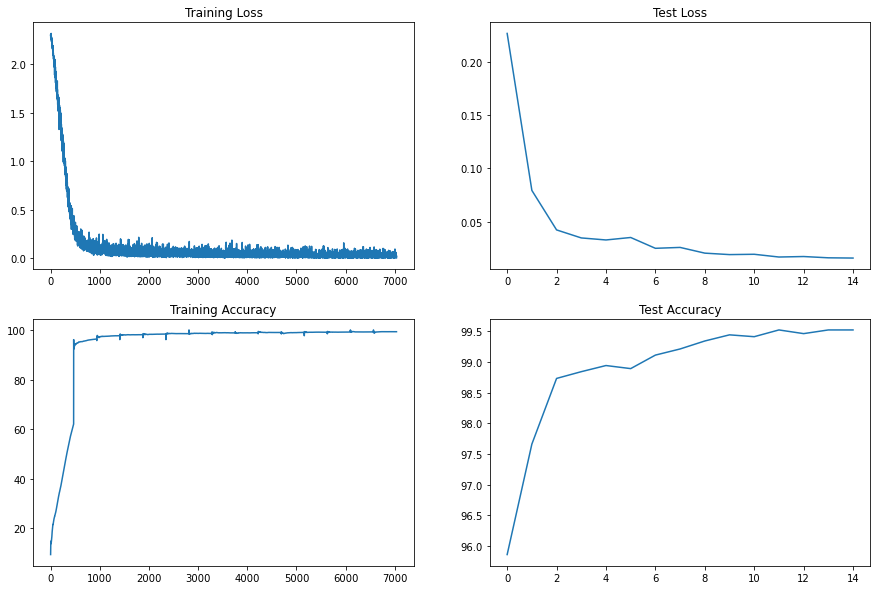

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

#### Target:
1. We took the last model provided in the module as a base point to start with.
2. As a first step, we added a new one cycle learning rate scheduler, to obtain a better stable learning curve.
3. This sets up the learning rate of each parameter group according to the 1cycle learning rate policy.
   Thereby, increasing the chances of getting a better stable accuracy.

#### Results:
Parameters: 13,808
Best Train Accuracy: 99.28
Best Test Accuracy: 99.52% (12th Epoch)

#### Analysis:
1. This experiment proved that the use of learning rate scheduler helped the model to learn much better and stabilise better.
2. But, since the model parameters is too high, we would have to reduce the channels used in the model.
3. Although this might reduce the accuracy of the model, we would have to figure out some ways to maximise the efficiency of the model.